<a href="https://colab.research.google.com/github/NotMyMonkey/PyTorch/blob/main/TwitterSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Data import and overview**

In [ ]:
# importing libraries

import pandas as pd
import numpy as np
import seaborn as sn
import re
import random
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import matplotlib.pyplot as plt
#!pip install emoji --upgrade
import emoji
#!pip install contractions
import contractions
!pip install -U scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [ ]:
# importing data

from google.colab import files

files.upload()

{}

In [ ]:
df = pd.read_csv('AirlineSentimentTweets2.csv')

In [ ]:
df.head()

,textID,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,tweet_text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/02/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/02/2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
df.tail()

,textID,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,tweet_text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,5.695880e+17,positive,0.3487,NaN,0.0000,American,NaN,KristenReenders,NaN,0,@AmericanAir thank you we got on a different f...,NaN,22/02/2015 12:01,NaN,NaN
14636,5.695870e+17,negative,1.0000,Customer Service Issue,1.0000,American,NaN,itsropes,NaN,0,@AmericanAir leaving over 20 minutes Late Flig...,NaN,22/02/2015 11:59,Texas,NaN
14637,5.695870e+17,neutral,1.0000,NaN,NaN,American,NaN,sanyabun,NaN,0,@AmericanAir Please bring American Airlines to...,NaN,22/02/2015 11:59,"Nigeria,lagos",NaN
14638,5.695870e+17,negative,1.0000,Customer Service Issue,0.6659,American,NaN,SraJackson,NaN,0,"@AmericanAir you have my money, you change my ...",NaN,22/02/2015 11:59,New Jersey,Eastern Time (US & Canada)
14639,5.695870e+17,neutral,0.6771,NaN,0.0000,American,NaN,daviddtwu,NaN,0,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,22/02/2015 11:58,"dallas, TX",NaN


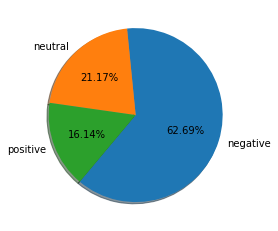

In [ ]:
# pie chart visualisation of sentiment split
sentiment_counts = df["sentiment"].value_counts()

plt.pie(sentiment_counts, labels=sentiment_counts.index,
        autopct='%1.2f%%', shadow=True, startangle=230)
plt.show()

In [ ]:
# total sentiment conunts
print(sentiment_counts)

negative    9178
neutral     3099
positive    2363
Name: sentiment, dtype: int64


**2. Data cleaning and text normalisation**

In [ ]:
# remove emoji characters and replace with meaningful text using emoji package

def demojize(tweet):
  tweet = emoji.demojize(tweet)
  return tweet
#end def

In [ ]:
# remove 'RT' retweet tag

def replace_retweet(tweet, default_replace=""):
  tweet = re.sub('RT\s+', default_replace, tweet)
  return tweet
#end def

In [ ]:
# remove '@' tag

def replace_user(tweet, default_replace="twitteruser"):
  tweet = re.sub('\B@\w+', default_replace, tweet)
  return tweet
#end def

In [ ]:
# replace URLs

def replace_url(tweet, default_replace=""):
  tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)
  return tweet
#end def

In [ ]:
# replace hashtags

def replace_hashtag(tweet, default_replace=""):
  tweet = re.sub('#+', default_replace, tweet)
  return tweet
#end def

In [ ]:
# remove capitalisation

def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet
#end def

In [ ]:
# replace repitition

def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet
#end def

In [ ]:
# remove repetitive punctuation

def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet
#end def

In [ ]:
# word contraction fix

def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet
#end def

Tokenisation:

In [ ]:
# create list of stopwords for tokenisation

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.discard('not') # remove word 'not' from list

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# tokenisation function
nltk.download('punkt')
def custom_tokenize(tweet,
                    keep_punct = False,
                    keep_alnum = False,
                    keep_stop = False):
  
  token_list = word_tokenize(tweet)

  if not keep_punct:
    token_list = [token for token in token_list
                  if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list
#end def

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Stemming:

In [ ]:
# stemming function

def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list
#end def

In [ ]:
# funct to process text using above preprocessing functions

def process_tweet(tweet, verbose=False):
  if verbose: print("Initial tweet: {}".format(tweet))

  # text cleaning
  tweet = replace_retweet(tweet) # replace retweet
  tweet = replace_user(tweet, "") # replace user tag
  tweet = replace_url(tweet) # replace url
  tweet = replace_hashtag(tweet) # replace hashtag
  if verbose: print("Post Twitter processing tweet: {}".format(tweet))
  tweet = to_lowercase(tweet) # lower case
  tweet = fix_contractions(tweet) # replace contractions
  tweet = punct_repetition(tweet) # replace punctuation repetition
  tweet = word_repetition(tweet) # replace word repetition
  tweet = demojize(tweet) # replace emojis
  if verbose: print("Post Word processing tweet: {}".format(tweet))

  # tokenisation/stemming
  tokens = custom_tokenize(tweet, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem
#end def

In [ ]:
# apply function to whole dataframe

df["tokens"] = df["tweet_text"].apply(process_tweet)
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1
                                              if i == "positive" else 0)


In [ ]:
df.head()

,textID,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,tweet_text,tweet_coord,tweet_created,tweet_location,user_timezone,tokens,tweet_sentiment
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/02/2015 11:35,NaN,Eastern Time (US & Canada),[said],0
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada),"[plus, ad, commerci, experi, tacki]",1
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/02/2015 11:15,Lets Play,Central Time (US & Canada),"[not, today, must, mean, need, take, anoth, trip]",0
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/02/2015 11:15,NaN,Pacific Time (US & Canada),"[realli, aggress, blast, obnoxi, entertain, gu...",0
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/02/2015 11:14,NaN,Pacific Time (US & Canada),"[realli, big, bad, thing]",0


In [ ]:
# create X (tokens) and y (sentiment) lists 

X = df["tokens"].tolist()
y = df["tweet_sentiment"].tolist()

In [ ]:
# split X and y into training/testing at 80:20 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=0,
                                                    train_size=0.80)

In [ ]:
# funct to fit LR model to training data

def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model
#end def

In [ ]:
# funct that creates TF-IDF vectoriser

def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                            tokenizer=lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect
#end def

In [ ]:
#data transformation

tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  " since 'analyzer' != 'word'")


**3: Modelling**

In [ ]:
# fit regression model to data

model_lr_tf = fit_lr(X_train_tf, y_train)

In [ ]:
# 

y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))

LR Model Accuracy: 90.81%


<module 'seaborn' from '/usr/local/lib/python3.7/dist-packages/seaborn/__init__.py'>

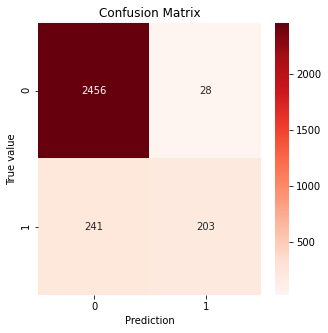

In [ ]:
# confusion matrix

def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Reds", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

plot_confusion(confusion_matrix(y_test, y_pred_lr_tf))